### first part
<div>
    at the first part we try to clean and prepare data. <br>
</div>

In [1]:
## import requiremets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
import math
import seaborn as sns

In [2]:
path_dataset = "2018-02Final.csv" ## enter your path here
df = pd.read_csv(path_dataset, index_col=0)
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,771.0,2018-02-01 00:14:16.4120,2018-02-01 00:27:08.2290,72,W 52 St & 11 Ave,40.767272,-73.993929,379,W 31 St & 7 Ave,40.749156,-73.991600,14536,Subscriber,1952,1
1,264.0,2018-02-01 05:14:45.1790,2018-02-01 05:19:09.6860,72,W 52 St & 11 Ave,40.767272,-73.993929,478,11 Ave & W 41 St,40.760301,-73.998842,32820,Subscriber,1965,1
2,819.0,2018-02-01 06:48:55.2290,2018-02-01 07:02:35.0290,72,W 52 St & 11 Ave,40.767272,-73.993929,405,Washington St & Gansevoort St,40.739323,-74.008119,16131,Subscriber,1968,1
3,646.0,2018-02-01 07:12:50.1740,2018-02-01 07:23:36.5280,72,W 52 St & 11 Ave,40.767272,-73.993929,2006,Central Park S & 6 Ave,40.765909,-73.976342,20831,Subscriber,1990,2
4,1312.0,2018-02-01 07:46:48.8750,2018-02-01 08:08:41.5430,72,W 52 St & 11 Ave,40.767272,-73.993929,435,W 21 St & 6 Ave,40.741740,-73.994156,15899,Subscriber,1957,1


In [3]:
"""
    fill start station latitude and start station longtitude with correct value.
    mode of values replaced with current values 
"""
for x in ["start", "end"]:
    stations = df[f"{x} station id"].unique()
    for station in stations:
        mode = df[df[f"{x} station id"] == station][f"{x} station latitude"].mode().iloc[0]
        df.loc[df[f"{x} station id"] == station, f"{x} station latitude"] = mode

"""convert to datetime"""
df["starttime"] = pd.to_datetime(df["starttime"])
df["stoptime"] = pd.to_datetime(df["stoptime"])

"""delete naT values"""
df = df[~df.starttime.isnull()]

""" add age instead of birth date"""
df["age"] = date.today().year - df["birth year"]
df.drop("birth year", axis=1, inplace=True)

"""not needed in our analysis"""
df.drop(["start station name", "end station name"], axis=1, inplace=True)

## see differences
df.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,gender,age
0,771.0,2018-02-01 00:14:16.412,2018-02-01 00:27:08.229,72,40.767272,-73.993929,379,40.749156,-73.991600,14536,Subscriber,1,70
1,264.0,2018-02-01 05:14:45.179,2018-02-01 05:19:09.686,72,40.767272,-73.993929,478,40.760301,-73.998842,32820,Subscriber,1,57
2,819.0,2018-02-01 06:48:55.229,2018-02-01 07:02:35.029,72,40.767272,-73.993929,405,40.739323,-74.008119,16131,Subscriber,1,54
3,646.0,2018-02-01 07:12:50.174,2018-02-01 07:23:36.528,72,40.767272,-73.993929,2006,40.765909,-73.976342,20831,Subscriber,2,32
4,1312.0,2018-02-01 07:46:48.875,2018-02-01 08:08:41.543,72,40.767272,-73.993929,435,40.741740,-73.994156,15899,Subscriber,1,65


In [4]:
def part_of_day(hour, minute):
    "this function returns the part of the day based of project definition"
    return hour*4 + int(minute/4)

df["part_of_day"] = df["starttime"].apply(lambda x: part_of_day(x.hour, x.minute))
df["hour_of_day"] = df["starttime"].apply(lambda x: x.hour)

In [6]:
bike_df = pd.read_excel("BikeType.xlsx")
bike_df = bike_df[["type", "bikeID"]]

"""
    convert current excel file to appropriate format to merge main df
"""
col_bike = ["type_bike", "bikeid"]
bike_df_ = pd.DataFrame(columns = col_bike)

for i in bike_df.index:
    bike_ids = bike_df.loc[i, "bikeID"].split()
    for id in bike_ids:
        bike_df_ = bike_df_.append(
            pd.Series([
                bike_df.loc[i, "type"], 
               int(id),
            ],
            index = col_bike
            ), ignore_index = True
        )
bike_df_.head()

,type_bike,bikeid
0,classic-bike,14529
1,classic-bike,14530
2,classic-bike,14531
3,classic-bike,14532
4,classic-bike,14533


In [7]:
df = df.merge(bike_df_, how='left',on="bikeid" )
df.drop("bikeid", axis=1, inplace=True)

In [8]:
## od matrix
odf = df.loc[:, ["start station id", "end station id"]]
resul = pd.DataFrame(0, index=stations, columns =stations
                ).add(odf.pivot_table(values='end station id', index="start station id",
                                     columns='end station id', aggfunc=len),
                      fill_value=0).astype('int')
resul

,72,79,82,83,119,120,127,128,143,144,...,3654,3656,3658,3659,3660,3661,3662,3663,3664,3668
72,33,4,0,0,0,0,8,2,0,0,...,0,1,5,1,2,0,0,0,1,0
79,12,45,0,0,0,0,25,9,0,0,...,0,4,3,0,3,0,0,0,11,0
82,0,0,19,0,0,1,0,1,0,0,...,0,5,1,0,0,0,0,0,0,0
83,0,0,0,8,1,10,0,1,1,1,...,0,0,0,0,0,1,0,1,0,0
119,0,0,0,0,1,0,0,1,0,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,0,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
3662,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,3,0,0,0
3663,0,0,0,9,0,3,0,1,0,0,...,0,0,0,0,0,0,0,4,0,0
3664,7,15,0,0,0,0,12,9,0,0,...,0,5,3,0,1,0,0,0,22,0


### second part

#### Exploratory data analysis
- features
- distributions
- plots to get better intuition

In [9]:
df.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,usertype,gender,age,part_of_day,hour_of_day,type_bike
0,771.0,2018-02-01 00:14:16.412,2018-02-01 00:27:08.229,72,40.767272,-73.993929,379,40.749156,-73.991600,Subscriber,1,70,3,0,classic-bike
1,264.0,2018-02-01 05:14:45.179,2018-02-01 05:19:09.686,72,40.767272,-73.993929,478,40.760301,-73.998842,Subscriber,1,57,23,5,docked-bike
2,819.0,2018-02-01 06:48:55.229,2018-02-01 07:02:35.029,72,40.767272,-73.993929,405,40.739323,-74.008119,Subscriber,1,54,36,6,classic-bike
3,646.0,2018-02-01 07:12:50.174,2018-02-01 07:23:36.528,72,40.767272,-73.993929,2006,40.765909,-73.976342,Subscriber,2,32,31,7,classic-bike
4,1312.0,2018-02-01 07:46:48.875,2018-02-01 08:08:41.543,72,40.767272,-73.993929,435,40.741740,-73.994156,Subscriber,1,65,39,7,classic-bike


In [10]:
### age
df.age.describe().astype(int).reset_index()

,index,age
0,count,842613
1,mean,43
2,std,12
3,min,20
4,25%,34
5,50%,42
6,75%,53
7,max,137


In [11]:
### part of day
df.part_of_day.describe().astype(int).reset_index()

,index,part_of_day
0,count,842613
1,mean,61
2,std,19
3,min,0
4,25%,44
5,50%,63
6,75%,77
7,max,106


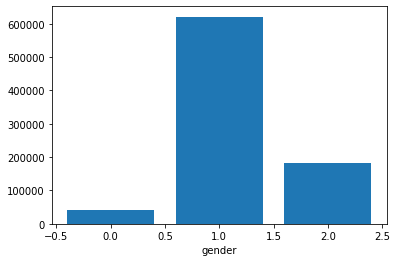

In [12]:
### gender
people_count = df.gender.value_counts()
plt.bar(people_count.keys(),people_count.values)
plt.xlabel("gender")
plt.show()


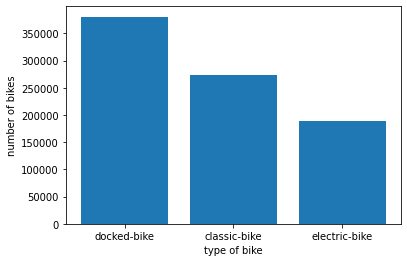

In [13]:
bike_types= df.type_bike.value_counts()
plt.bar(bike_types.keys(), bike_types.values)
plt.ylabel("number of bikes")
plt.xlabel("type of bike")
plt.show()

In [14]:
## describe trip durations
df.tripduration.describe().astype(int).reset_index()

,index,tripduration
0,count,842113
1,mean,877
2,std,33903
3,min,61
4,25%,319
5,50%,519
6,75%,872
7,max,15962256


In [15]:
def calculate_distance(item: pd.Series) -> float:
    """this function calculates distance in kilo-meter
        Parameters:
        ------------
            - item: pd.Series 
                a record of dataframe
    """

    R = 6373.0
    lat1 = math.radians(item["start station latitude"])
    lon1 = math.radians(item["start station longitude"])
    lat2 = math.radians(item["end station latitude"])
    lon2 = math.radians(item["end station longitude"])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

def calculate_velocity(item: pd.Series) -> float:
    """this function calculates velocity in km/h
    Parameters:
        ------------
            - item: pd.Series 
                a record of dataframe
    """
    return item["distance"] / item["tripduration"] * 3600

In [16]:
df["distance"] = df.apply(calculate_distance, axis=1)
df["velocity"] = df.apply(calculate_velocity, axis=1)

In [17]:
mean_velocity = df.velocity.mean()
std_velocity = df.velocity.std()

### remove outliers to see velocity distribution. we use alfa=0.05 so k0.025= 1.96
df = df[df.velocity > mean_velocity - 1.96 * std_velocity][df.velocity < mean_velocity + 1.96 * std_velocity]

<ipython-input-17-4847cd486699>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.velocity > mean_velocity - 1.96 * std_velocity][df.velocity < mean_velocity + 1.96 * std_velocity]


<AxesSubplot:xlabel='velocity', ylabel='Count'>

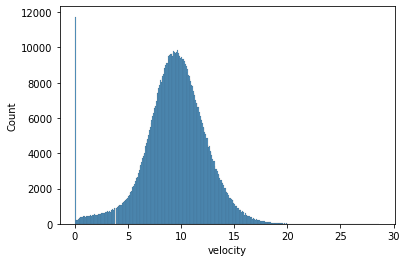

In [18]:
### a nice normal distribution as expected
sns.histplot(df.velocity)

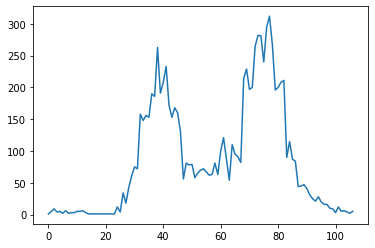

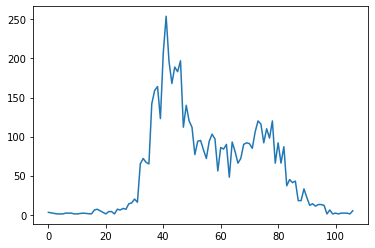

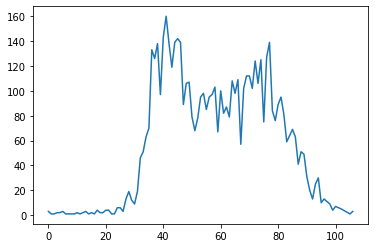

In [19]:
## trips base on part of day for three high traffic stations
plt.plot(df[df["end station id"] == 519].groupby("part_of_day")["end station id"].count())
plt.show()
plt.plot(df[df["end station id"] == 402].groupby("part_of_day")["end station id"].count())
plt.show()
plt.plot(df[df["end station id"] == 435].groupby("part_of_day")["end station id"].count())
plt.show()


### third part

#### velocity analysis and find best new-station location

In [20]:
velocity_df = df.groupby(["type_bike", "usertype", "gender"])["velocity"].mean().reset_index()

<AxesSubplot:xlabel='usertype'>

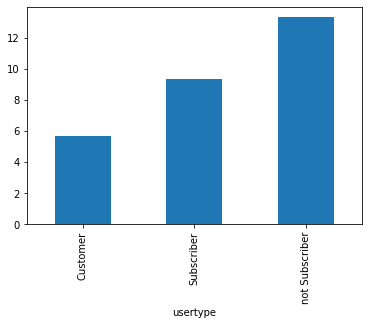

In [21]:
## difference between different types of users
velocity_df.groupby("usertype")["velocity"].mean().plot.bar()

In [22]:
## velocity in different genders are almost the same type one are little faster!
velocity_df.groupby("gender")["velocity"].mean()

gender
0    7.437334
1    8.693400
2    7.214821
Name: velocity, dtype: float64

In [23]:
## electric bikes seems to be faster! two other types are almost the same
velocity_df.groupby("type_bike")["velocity"].mean()

type_bike
classic-bike     7.412157
docked-bike      7.564991
electric-bike    8.414835
Name: velocity, dtype: float64

In [24]:
feature_sort = "start station id"
sorted_stations = df[feature_sort].value_counts().keys() # numpy array
station_df = df.drop_duplicates(subset=[feature_sort])
station_df = station_df[[feature_sort ,"start station latitude", "start station longitude"]].reset_index().drop("index", axis=1)


In [25]:
def station_location(station_id):
    return station_df[station_df[feature_sort] == station_id].values[0]

def center_of_gravity(station1: np.array, station2:np.array, station3:np.array):
    """find center of 3 stations"""
    lat1 = station1[1]
    lon1 = station1[2]
    lat2 = station2[1]
    lon2 = station2[2]
    lat3 = station3[1]
    lon3 = station3[2]
    return (lat1 + lat2 + lat3)/3 , (lon1 + lon2 + lon3)/3

def calculate_distance(new_station:np.array, station:pd.Series):
    R = 6373.0
    lat1 = math.radians(new_station[0])
    lon1 = math.radians(new_station[1])
    lat2 = math.radians(station["start station latitude"])
    lon2 = math.radians(station["start station longitude"])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

In [26]:
j=0
mean_velocity = df.velocity.mean()
distance_2min = 2 * mean_velocity /60

def get_new_station_location():
    for i in range(len(sorted_stations)):
        station1 = station_location(sorted_stations[i])
        station2 = station_location(sorted_stations[i+1])
        station3 = station_location(sorted_stations[i+2])

        new_station = center_of_gravity(station1, station2, station3)

        for id in station_df.index:
            j=id
            dist = calculate_distance(new_station, station_df.iloc[id])
            if dist < distance_2min:
                break
        if j == station_df.shape[0]-1:
            return new_station, i


mew_station_location, index_i = get_new_station_location()

In [27]:
## 3 stations we must build a new one in center of these stations
sorted_stations[index_i:index_i+3]

Int64Index([432, 358, 382], dtype='int64')

In [28]:
## location of new station
mew_station_location

(40.731353453333334, -73.96561977943756)